# Using Aviation Edge and OpenSky APIs for historical data analysis

## Phase 1: Data Collection

### Real-Time Flight Data

In [1]:
# Importing modules

import requests
import pandas as pd
import numpy as np
import nest_asyncio
import asyncio
from datetime import datetime, timedelta
import time
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Setting up OpenSky

from python_opensky import OpenSky
nest_asyncio.apply()

class AirCanadaDataCollector:
    def __init__(self):
        self.flight_data = []
        self.historical_data = pd.DataFrame()   #Dataframe for storing Air Canada Flights
    
    async def collect_realtime_flights(self):
        """Collects current Air Canada flight data"""
        async with OpenSky() as opensky:
            
            # Getting most recent flight data
            states = await opensky.get_states()
            
            ac_flights = []

            # Filtering to get Air Canada flight data only
            for state in states.states:
                if state.callsign and state.callsign.strip().startswith('ACA'):
                    flight_info = {
                        'timestamp': datetime.now(),
                        'callsign': state.callsign.strip(),
                        'icao24': state.icao24,
                        'longitude': state.longitude,
                        'latitude': state.latitude,
                        'altitude': state.barometric_altitude,
                        'velocity': state.velocity,
                        'heading': state.true_track,
                        'vertical_rate': state.vertical_rate,
                        'on_ground': state.on_ground
                    }

                    # Adds the current Air Canada flight details to the list
                    ac_flights.append(flight_info)
            
            return pd.DataFrame(ac_flights)
    
    async def collect_historical_flights(self, start_time, end_time):
        """Collects historical flight data for a specific time range"""
        async with OpenSky() as opensky:
            # OpenSky provides historical data access
            flights = await opensky.get_flights_by_aircraft(
                begin=int(start_time.timestamp()),
                end=int(end_time.timestamp())
            )
            return flights

# Initializes collector object
collector = AirCanadaDataCollector()

# Collectes current flights
current_flights = await collector.collect_realtime_flights()
print(f"Collected {len(current_flights)} current Air Canada flights")
print(current_flights)

Collected 94 current Air Canada flights
                    timestamp callsign  icao24  longitude  latitude  altitude  \
0  2025-09-04 23:26:04.438135  ACA1071  c07e2c   -96.0212   33.4741   5158.74   
1  2025-09-04 23:26:04.438135   ACA595  c07e33   -85.1782   40.3133  10972.80   
2  2025-09-04 23:26:04.438135   ACA920  c058c2   -72.5746   45.2127  11887.20   
3  2025-09-04 23:26:04.438135   ACA900  c058c3   -73.7372   45.4823       NaN   
4  2025-09-04 23:26:04.438135   ACA808  c058bf   -79.6147   43.6744       NaN   
..                        ...      ...     ...        ...       ...       ...   
89 2025-09-04 23:26:04.439135   ACA852  c04fdd   -79.0400   44.8124   7482.84   
90 2025-09-04 23:26:04.439135   ACA299  c00700  -108.1876   51.4879  10988.04   
91 2025-09-04 23:26:04.439135   ACA118  c0192e   -79.9248   43.9316   3299.46   
92 2025-09-04 23:26:04.439135   ACA157  c00821   -81.4132   44.7529   9753.60   
93 2025-09-04 23:26:04.439135   ACA645  c00757  -123.1895   49.2019  

### Air Canada Route and Schedule Data

In [3]:
# Creating a class processing airport data and identifying high traffic routes

class AirCanadaRoute:
    def __init__(self):
        self.major_hubs = ["YUL", "YYZ", "YYC", "YVR"]  # Major Hubs: Montreal, Toronto & Vancouver
        self.route_data = []

    def get_airport_data(self):
        """Gets airport traffic data from reliable sources (yyc.com, admtl.com, internationalairportreview.com and torontopearson.com)"""
        
        airport_data = {
            "YUL" : {"name": "Montreal Trudeau", "annual_passengers": "22400000"},
            "YYZ" : {"name": "Toronto Pearson", "annual_passengers": "46800000"},
            "YVR" : {"name": "Vancouver International", "annual_passengers": "26200000"}
        }
        return airport_data

    def identify_high_traffic_routes(self, flight_data):
        """Identifies highest traffic routes for analysis"""
        route_frequency = {}
        
        for _, flight in flight_data.iterrows():

            # Extracts route information from callsign patterns
            callsign = flight["callsign"]
            
            # Air Canada uses specific callsign patterns for different routes
            if callsign.startswith('ACA'):
                flight_number = callsign[3:]

                # Key: flight_number, value: route_frequency
                route_frequency[flight_number] = route_frequency.get(flight_number, 0) + 1
        return dict(sorted(route_frequency.items(), key=lambda x:x[1], reverse=True))

In [4]:
#  Creating AirCanadaRoute objects

route_collector = AirCanadaRoute()
airport_data = route_collector.get_airport_data()
high_traffic_routes = route_collector.identify_high_traffic_routes(current_flights)

In [5]:
print(high_traffic_routes)

{'1071': 1, '595': 1, '920': 1, '900': 1, '808': 1, '922': 1, '670': 1, '270': 1, '57': 1, '18': 1, '870': 1, '790': 1, '186': 1, '124': 1, '127': 1, '793': 1, '723': 1, '119': 1, '884': 1, '995': 1, '1359': 1, '1041': 1, '515': 1, '634': 1, '1152': 1, '271': 1, '650': 1, '313': 1, '941': 1, '990': 1, '1301': 1, '779': 1, '185': 1, '777': 1, '223': 1, '842': 1, '812': 1, '795': 1, '471': 1, '245': 1, '993': 1, '427': 1, '818': 1, '745': 1, '996': 1, '792': 1, '338': 1, '559': 1, '722': 1, '2330': 1, '856': 1, '175': 1, '2334': 1, '527': 1, '224': 1, '144': 1, '546': 1, '579': 1, '97': 1, '2145': 1, '558': 1, '262': 1, '763': 1, '757': 1, '307': 1, '311': 1, '43': 1, '872': 1, '890': 1, '820': 1, '880': 1, '122': 1, '158': 1, '511': 1, '429': 1, '742': 1, '312': 1, '616': 1, '1373': 1, '153': 1, '121': 1, '129': 1, '828': 1, '1063': 1, '7202': 1, '876': 1, '395': 1, '1049': 1, '814': 1, '852': 1, '299': 1, '118': 1, '157': 1, '645': 1}


### External Data Collection (Weather, Holidays & Seasonal Factors)

In [6]:
class ExternalDataCollector:
    def __init__(self):
        # Processes weather data from 'api.weather.gc.ca' and public holidays for later use
        
        self.weather_api = "https://api.weather.gc.ca"
        self.geomet_api = "https://api.weather.gc.ca/collections"

        self.major_hubs = {
            'YUL': {'name': 'Montreal Trudeau', 'lat': 45.4706, 'lon': -73.7408, 'passengers': 22400000},
            'YYZ': {'name': 'Toronto Pearson', 'lat': 43.6777, 'lon': -79.6248, 'passengers': 46800000},
            'YVR': {'name': 'Vancouver International', 'lat': 49.1967, 'lon': -123.1815, 'passengers': 26200000}
        }
        
        self.holidays_2025 = [
            "2025-01-01",  # New Year's Day
            "2025-04-18",  # Good Friday
            "2025-05-19",  # Victoria Day
            "2025-07-01",  # Canada Day
            "2025-09-01",  # Labour Day
            "2025-10-13",  # Thanksgiving
            "2025-11-11",  # Remembrance Day
            "2025-12-25",  # Christmas Day
            "2025-12-26"   # Boxing Day
        ]
    
    def get_weather_data(self, airport_code, date):
        """Gets weather data for specific airports for specific dates"""

        if airport_code not in self.major_hubs:
            return None

        hub_info = self.major_hubs[airport_code]

        # Uses GeoMet API for current weather observation based on real-time weather data
        weather_url = f"{self.geomet_api}/weather-observations/items"
        params = {
            'bbox': f"{hub_info['lon']-0.1},{hub_info['lat']-0.1},{hub_info['lon']+0.1},{hub_info['lat']+0.1}",
            'datetime': date.strftime('%Y-%m-%dT%H:%M:%SZ'),
            'limit': 1 
        }
        
        response = requests.get(weather_url, params=params, timeout=10)

        # Only proceeds if the weather data is obtained
        if response.status_code == 200:
            data = response.json()  #Correcting response format

            if data.get('features'):
                properties = data['features'][0]['properties']
                
                return {
                    'airport': airport_code,
                    'date': date,
                    'temperature': properties.get('air_temperature'),
                    'precipitation': properties.get('precipitation'),
                    'visibility': properties.get('visibility'),
                    'wind_speed': properties.get('wind_speed'),
                    'conditions': properties.get('weather_condition'),
                    'pressure': properties.get('pressure')
                }

    
    def is_holiday(self, date):
        """Checks if the specific date is a holiday or not"""
        
        date_str = date.strftime("%Y-%m-%d")
        return date_str in self.holidays_2025

    def get_seasonal_factors(self, date):
        """Gets seasonal adjustment factors"""
        
        month = date.month
        seasons = {
            "winter_months": [12, 1, 2],
            "spring_months": [3, 4, 5],
            "summer_months": [6, 7, 8],
            "fall_months": [9, 10, 11]
        }

        for season, months in seasons.items():
            if month in months:
                return season
            else:
                return "Unknown"

In [7]:
# Creating ExternalDataCollector object

external_collector = ExternalDataCollector()

### Passenger Booking Pattern Simulator

In [8]:
# Realistic Passenger Booking Simulation since I don't have access to real passenger data immediately

class PassengerBookingSimulator:
    def __init__(self):
        # Passenger booking features that affects no-show probability
        
        self.fare_class = ["Basic", "Standard", "Flex", "Premium", "Business"]
        self.advance_purchase_window = [1, 7, 14, 30, 60, 90]  # Time in days
        self.passenger_types = ["Business", "Leisure", "VFR"]

    def generate_booking_data(self, flight_info, num_passengers = 180):
        """Generates realistic passenger booking data for a flight based on available research"""
        
        passengers = []

        for i in range(0, num_passengers):
            # Generates passenger features that research shows affect no-show rates

            advance_purchase = random.choice(self.advance_purchase_window)
            fare_class = random.choice(self.fare_class)
            passenger_type = random.choice(self.passenger_types)

            # Factors that co-relate with no-show probability according to research (https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d3572abdaf3d12bd8e85471b1b217c495f7662d9)
            base_no_show_prob = 0.12  # According to researches, the industry average is between 5%-15% with 12% being a commonly cited average

            if advance_purchase <= 7:
                base_no_show_prob *= 0.7  # Last-minute bookings are less likely to be a no-show. Based on 30% reduction for last minute booking is based on general industry logic

            if fare_class in ["Premium", "Business"]:
                base_no_show_prob *= 0.5  # Premium and Business bookings are less likely to be a no-show. More of an assumption so 50/50 chances

            if passenger_type == "Business":
                base_no_show_prob *= 0.6  # Passengers travelling for business are less likely to be a no-show. 40% reduction for business travelers is based on general industry logic

            passenger = {
                "passenger_id": f"PAX_{flight_info['callsign']}_{i:03d}",
                "flight_callsign": flight_info["callsign"],
                "booking_data": datetime.now() - timedelta(days= advance_purchase),
                "advance_purchase_days": advance_purchase,
                "fare_class": fare_class,
                "passenger_type": passenger_type,
                "predicted_no_show_prob": min(base_no_show_prob, 0.15),  # Caps at 15%
                "actual_no_show": random.random() > base_no_show_prob  # Returns boolean
            }
            passengers.append(passenger)

        return pd.DataFrame(passengers)

In [9]:
# Creating PassengerBookingSimulation object

passenger_simulation = PassengerBookingSimulator()

### Building a data collection pipeline

In [10]:
# AirCanadaPipeline class collects real-time flight details, analyzes the routes, collects external data for each flight and predicts the no show rate

In [11]:
class AirCanadaPipeline:

    def __init__(self):
        
        # Initializing all the objects
        self.flight_collector = AirCanadaDataCollector()
        self.route_collector = AirCanadaRoute()
        self.external_data_collector = ExternalDataCollector()
        self.passenger_simulator = PassengerBookingSimulator()

    async def run_complete_collection(self):
        """Runs the complete data collection"""
        print("Starting Air Canada Data Collection...")

        # Collects real-time Air Canada flight data
        print("Collecting real-time flight data...")
        current_flights = await self.flight_collector.collect_realtime_flights()
        
        # Analyze the routes for the flights
        print("Analyzing flight route patterns...")
        high_traffic_routes = self.route_collector.identify_high_traffic_routes(current_flights)
        
        # Collect external data for each flights
        print("Collecting external factors...")
        tuned_flights = []

        # Iterates through each flight
        for _, flight, in current_flights.iterrows():
            
            # Adds weather data
            weather = self.external_data_collector.get_weather_data("YYZ", datetime.now())

            # Adds holiday data
            is_holiday = self.external_data_collector.is_holiday(datetime.now())

            # Adds seasonal factor
            season = self.external_data_collector.get_seasonal_factors(datetime.now())

            # Runs passenger booking simulation for this flight
            passengers = self.passenger_simulator.generate_booking_data(flight)

            tuned_flight = {
                **flight.to_dict(),  # Converts the flight data to dictionary representation
                "weather_conditions": weather,
                "is_holiday": is_holiday,
                "season": season,
                "passenger_count": len(passengers),
                "predicted_no_shows": passengers["predicted_no_show_prob"].sum(),   # Predicted number of no-show passengers
                "historical_no_show_rate": passengers["predicted_no_show_prob"].mean()  # Average no-show rate for flight
            }

            tuned_flights.append(tuned_flight)  # Adds the simulation data to the tuned_flights list

        tuned_df = pd.DataFrame(tuned_flights)  # Creates DataFrame for the tuned_flights

        print(f"Complete! Collected data for {len(tuned_df)} flights.")
        print(f"Average predicted no-show rate: {tuned_df['historical_no_show_rate'].mean():.3f}")

        return tuned_df, high_traffic_routes

In [12]:
# Runs the Pipeline

pipeline = AirCanadaPipeline()
flight_data, route_analysis = await pipeline.run_complete_collection()
        
# Displays the output of pipeline

print("\n*** Air Canada Flight Analysis ***")
print(flight_data[['callsign', 'passenger_count', 'predicted_no_shows', 'historical_no_show_rate']].head())

print(f"\n*** Top 5 Air Canada Routes by Frequency: ***")
for route, frequency in list(route_analysis.items())[:5]:
    print(f"AC{route}: {frequency} flights observed.")
    

Starting Air Canada Data Collection...
Analyzing flight route patterns...
Complete! Collected data for 95 flights.
Average predicted no-show rate: 0.075

*** Air Canada Flight Analysis ***
  callsign  passenger_count  predicted_no_shows  historical_no_show_rate
0  ACA1071              180             12.5664                 0.069813
1   ACA595              180             13.3848                 0.074360
2   ACA920              180             13.7808                 0.076560
3   ACA900              180             13.5804                 0.075447
4   ACA808              180             13.5060                 0.075033

*** Top 5 Air Canada Routes by Frequency: ***
AC1071: 1 flights observed.
AC595: 1 flights observed.
AC920: 1 flights observed.
AC900: 1 flights observed.
AC808: 1 flights observed.


### Visualization

In [17]:
class DataVisualizer:
    def __init__(self, flight_data, route_analysis, airport_data):
        self.flight_data = flight_data
        self.route_analysis = route_analysis
        self.airport_data = airport_data
        
    def plot_no_show_rate_distribution(self):
        """Visualizing the distribution of predicted no-show rates"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histogram of no-show rates
        ax1.hist(self.flight_data['historical_no_show_rate'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Historical No-Show Rate')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of No-Show Rates Across Flights')
        ax1.grid(True, alpha=0.3)
        
        # Box plot per season
        if 'season' in self.flight_data.columns:
            sns.boxplot(data=self.flight_data, x='season', y='historical_no_show_rate', ax=ax2)
            ax2.set_title('No-Show Rates by Season')
            ax2.set_ylabel('Historical No-Show Rate')
        
        plt.tight_layout()
        plt.show()

    def plot_flight_map(self):
        """Creating an interactive map showing current Air Canada flights"""
        if len(self.flight_data) == 0 or self.flight_data['latitude'].isna().all():
            print("No flight location data available for mapping")
            return
        
        # Centers map on Canada
        m = folium.Map(location=[56.1304, -106.3468], zoom_start=4)
        
        # Adding flight markers
        for idx, flight in self.flight_data.iterrows():
            if pd.notna(flight['latitude']) and pd.notna(flight['longitude']):
                popup_text = f"""
                <b>Flight:</b> {flight['callsign']}<br>
                <b>Altitude:</b> {flight['altitude']:.0f} ft<br>
                <b>Velocity:</b> {flight['velocity']:.0f} knots<br>
                <b>Predicted No-Shows:</b> {flight['predicted_no_shows']:.1f}<br>
                <b>Passengers:</b> {flight['passenger_count']}
                """
                
                # Color code by no-show rate
                color = 'red' if flight['historical_no_show_rate'] > 0.12 else 'green'
                
                folium.CircleMarker(
                    location=[flight['latitude'], flight['longitude']],
                    radius=8,
                    popup=popup_text,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.7
                ).add_to(m)
        
        # Add major hub markers
        hub_coords = {
            'YUL': [45.4706, -73.7408],
            'YYZ': [43.6777, -79.6248], 
            'YVR': [49.1967, -123.1815]
        }
        
        for hub, coords in hub_coords.items():
            folium.Marker(
                location=coords,
                popup=f"<b>{hub}</b><br>{self.airport_data[hub]['name']}",
                icon=folium.Icon(color='blue', icon='plane')
            ).add_to(m)
        
        return m
    
    def plot_route_frequency(self):
        """Visualizing top Air Canada routes by frequency"""
        if not self.route_analysis:
            print("No route analysis data available")
            return
            
        # Gets the top 10 routes
        top_routes = dict(list(self.route_analysis.items())[:10])
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        routes = list(top_routes.keys())
        frequencies = list(top_routes.values())
        
        bars = ax.barh(range(len(routes)), frequencies, color='lightcoral')
        ax.set_yticks(range(len(routes)))
        ax.set_yticklabels([f'AC{route}' for route in routes])
        ax.set_xlabel('Flight Frequency')
        ax.set_title('Top 10 Air Canada Routes by Frequency')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                   f'{frequencies[i]}', ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
    
    def plot_passenger_metrics(self):
        """Visualing passenger count vs predicted no-shows"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Scatter plot: Passenger count vs No-show rate
        ax1.scatter(self.flight_data['passenger_count'], 
                   self.flight_data['historical_no_show_rate'],
                   alpha=0.6, color='purple')
        ax1.set_xlabel('Passenger Count')
        ax1.set_ylabel('Historical No-Show Rate')
        ax1.set_title('Passenger Count vs No-Show Rate')
        ax1.grid(True, alpha=0.3)
        
        # Box plot: Total predicted no-shows per flight
        flight_callsigns = self.flight_data['callsign'].head(10)
        predicted_no_shows = self.flight_data['predicted_no_shows'].head(10)
        
        ax2.bar(range(len(flight_callsigns)), predicted_no_shows, color='orange', alpha=0.7)
        ax2.set_xticks(range(len(flight_callsigns)))
        ax2.set_xticklabels(flight_callsigns, rotation=45, ha='right')
        ax2.set_ylabel('Predicted No-Shows')
        ax2.set_title('Predicted No-Shows by Flight (Top 10)')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def plot_hub_comparison(self):
        """Comparing major Air Canada hubs: Montreal, Toronto & Vancouver"""
        hubs = list(self.airport_data.keys())
        passengers = [int(self.airport_data[hub]['annual_passengers']) for hub in hubs]
        hub_names = [self.airport_data[hub]['name'] for hub in hubs]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        bars = ax.bar(hub_names, passengers, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax.set_ylabel('Annual Passengers (Millions)')
        ax.set_title('Air Canada Major Hub Comparison')
        ax.set_ylim(0, max(passengers) * 1.1)
        
        # Formats y-axis to show millions
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
        
        # Adding value labels on bars
        for bar, value in zip(bars, passengers):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{value/1e6:.1f}M', ha='center', va='bottom', fontweight='bold')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def create_dashboard(self):
        """Creates a dashboard with multiple visualizations"""
        print("=== Air Canada No-Show Rate Analysis Dashboard ===\n")
        
        print("1. No-Show Rate Distribution Analysis")
        self.plot_no_show_rate_distribution()
        
        print("\n2. Route Frequency Analysis")
        self.plot_route_frequency()
        
        print("\n3. Passenger Metrics Analysis")
        self.plot_passenger_metrics()
        
        print("\n4. Hub Comparison")
        self.plot_hub_comparison()

=== Air Canada No-Show Rate Analysis Dashboard ===

1. No-Show Rate Distribution Analysis


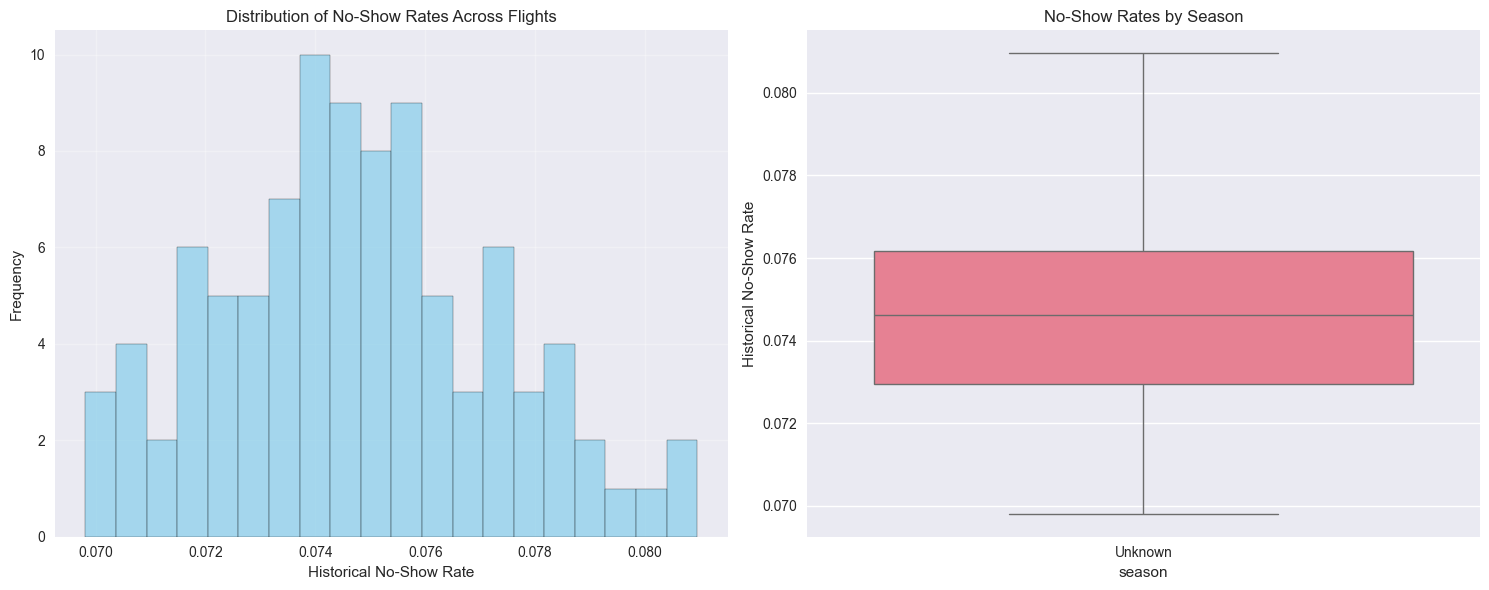


2. Route Frequency Analysis


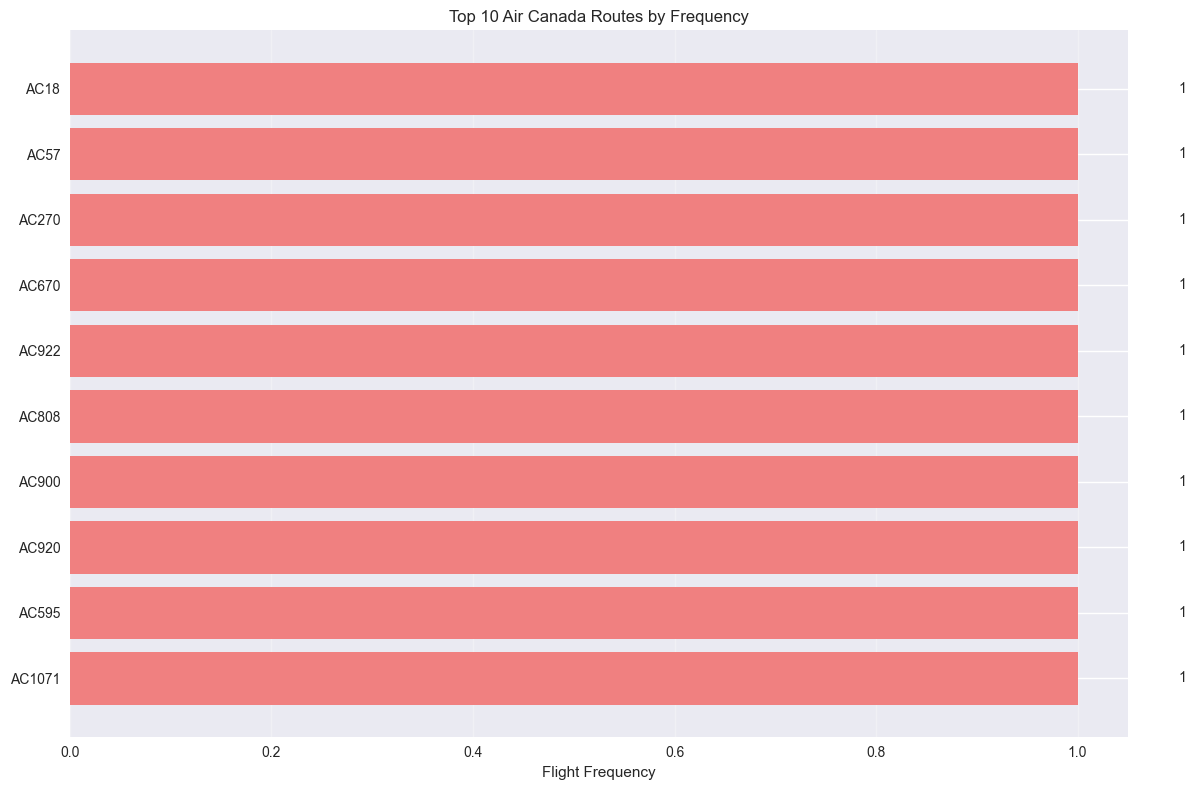


3. Passenger Metrics Analysis


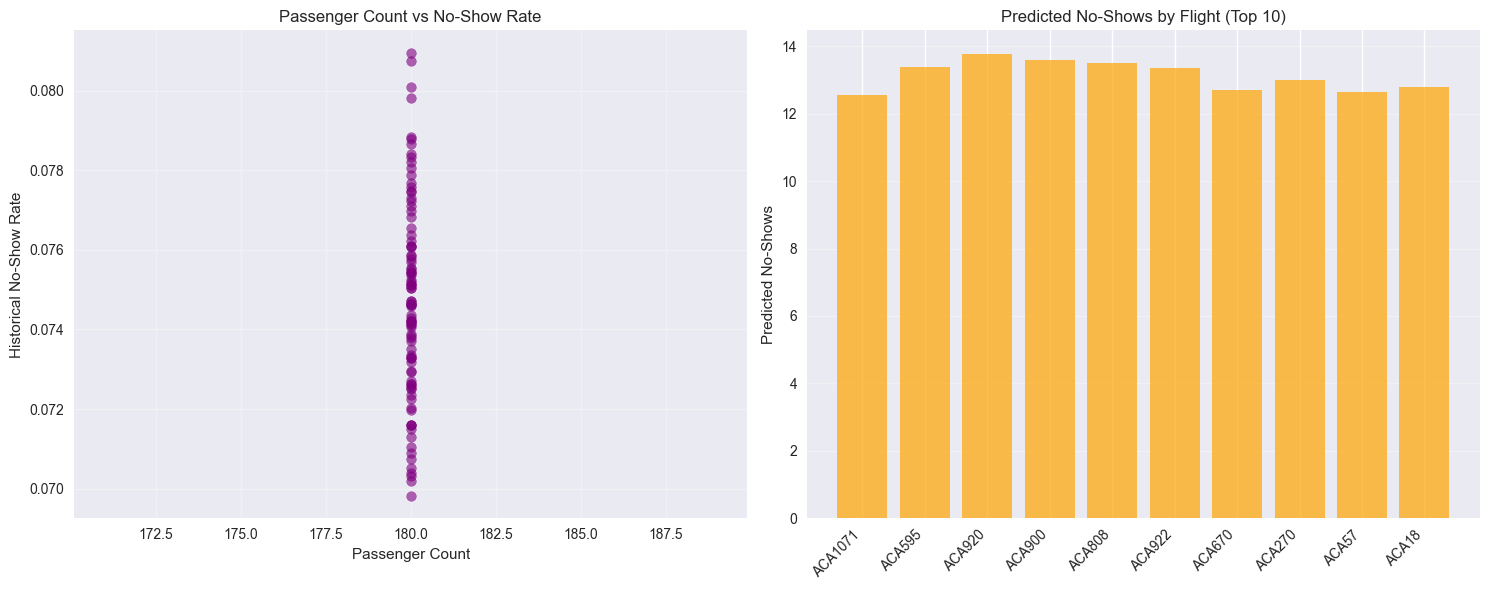


4. Hub Comparison


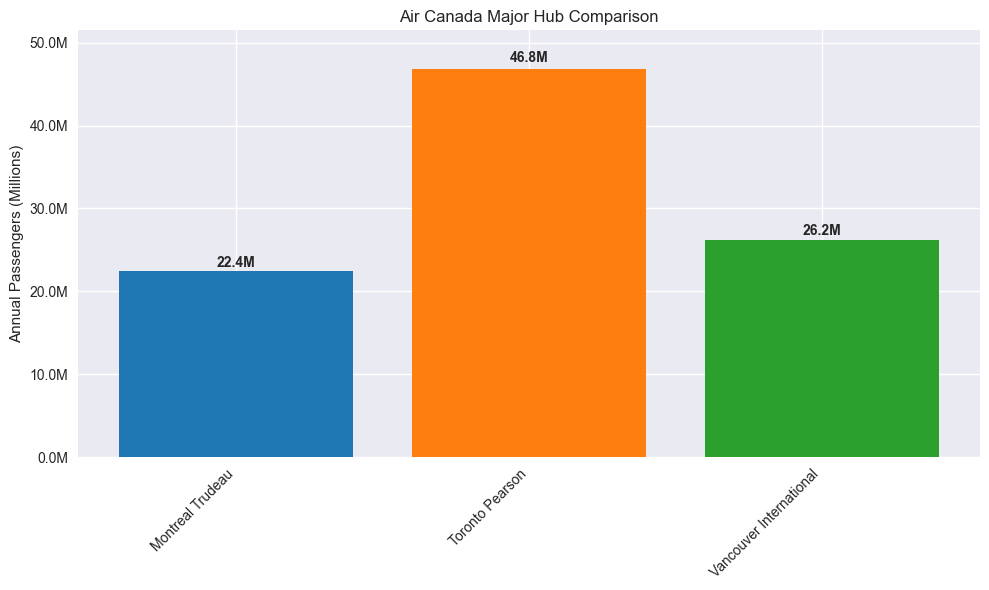

In [18]:
# Running the visualization

visual = DataVisualizer(flight_data, route_analysis, airport_data)

# Generates the complete dashboard
flight_map = visual.create_dashboard()

# Display the interactive map if available
if flight_map:
    flight_map